In [1]:

# ✅ Cell 0: Folder Creation (Run-based organization)


import os, json, random
from datetime import datetime
from pathlib import Path

PROJECT_DIR = "/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry"
Path(PROJECT_DIR).mkdir(parents=True, exist_ok=True)

DIRS = {
    "project": PROJECT_DIR,
    "runs": os.path.join(PROJECT_DIR, "runs"),
    "results": os.path.join(PROJECT_DIR, "results"),
}
for p in DIRS.values():
    os.makedirs(p, exist_ok=True)

def nowstamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

ts = nowstamp()
RUN_DIR = os.path.join(DIRS["runs"], f"run_{ts}")
os.makedirs(RUN_DIR, exist_ok=True)

ARTIFACTS = {
    "run_cfg": os.path.join(RUN_DIR, "run_cfg.json"),
    "train_log": os.path.join(RUN_DIR, "train_log.tsv"),
    "metrics": os.path.join(RUN_DIR, "metrics.json"),
    "errors": os.path.join(RUN_DIR, "errors.tsv"),
    "cm_png": os.path.join(RUN_DIR, "confusion_matrix.png"),
    "model_dir": os.path.join(RUN_DIR, "model"),
    "registry": os.path.join(DIRS["runs"], "registry.csv"),
}

print("PROJECT_DIR:", PROJECT_DIR)
print("RUN_DIR    :", RUN_DIR)
print("ARTIFACTS  :", ARTIFACTS)

PROJECT_DIR: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry
RUN_DIR    : /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328
ARTIFACTS  : {'run_cfg': '/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/run_cfg.json', 'train_log': '/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/train_log.tsv', 'metrics': '/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/metrics.json', 'errors': '/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/errors.tsv', 'cm_png': '/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/confusion_matrix.png', 'model_dir': '/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/model', 'registry': '/Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/registry.

In [2]:
# ✅ Cell 1: Imports & Device (Mac M4 Pro optimized)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
)

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# --- Device selection (Mac M4 Pro with MPS) ---
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) - Mac M4 Pro")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

print("DEVICE:", DEVICE)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # MPS doesn't need special seeding


Using MPS (Metal Performance Shaders) - Mac M4 Pro
DEVICE: mps


In [14]:
# ✅ Cell 2: Config (saved to run_cfg.json)
cfg = {
    "project": "clinc_oos_intent_run_registry",
    "dataset_name": "clinc_oos",
    "dataset_config": "plus",  # Try "plus" first, fallback to None if needed
    "model_name": "distilbert-base-uncased",

    # training
    "max_len": 128,
    "batch_size": 16,
    "lr": 2e-5,
    "epochs": 4,
    "seed": 42,
    "early_stopping_patience": 2,

    # lightweight mode
    "max_train_examples": 8000,
    "max_val_examples": 1000,
    "max_test_examples": 2000,
    "debug_max_steps_per_epoch": None,  # None for unlimited

    # split
    "split_seed": 42,
    "val_ratio": 0.1,
}

with open(ARTIFACTS["run_cfg"], "w") as f:
    json.dump(cfg, f, indent=2)

print("Saved run cfg:", ARTIFACTS["run_cfg"])
print(json.dumps(cfg, indent=2))


Saved run cfg: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/run_cfg.json
{
  "project": "clinc_oos_intent_run_registry",
  "dataset_name": "clinc_oos",
  "dataset_config": "plus",
  "model_name": "distilbert-base-uncased",
  "max_len": 128,
  "batch_size": 16,
  "lr": 2e-05,
  "epochs": 4,
  "seed": 42,
  "early_stopping_patience": 2,
  "max_train_examples": 8000,
  "max_val_examples": 1000,
  "max_test_examples": 2000,
  "debug_max_steps_per_epoch": null,
  "split_seed": 42,
  "val_ratio": 0.1
}


In [15]:
# ✅ Cell 3: Dataset Load & Split (auto-detect columns + create train/val/test)
def take_n(ds, n):
    """Limit dataset to n examples"""
    if n is None:
        return ds
    n = min(int(n), len(ds))
    return ds.select(range(n))

def detect_columns(ds):
    """Auto-detect text and label columns"""
    cols = ds.column_names
    text_candidates  = ["text", "sentence", "utterance", "question", "query"]
    label_candidates = ["label", "labels", "intent", "category", "class"]

    text_col  = next((c for c in text_candidates  if c in cols), None)
    label_col = next((c for c in label_candidates if c in cols), None)

    # Fallback: find string column for text
    if text_col is None:
        for c in cols:
            feat_type = str(type(ds.features.get(c)))
            if "string" in feat_type.lower() or "String" in str(ds.features.get(c)):
                text_col = c
                break

    # Fallback: find non-text column for label
    if label_col is None:
        for c in cols:
            if c != text_col:
                label_col = c
                break

    return text_col, label_col

set_seed(cfg["seed"])

# Load dataset with fallback
try:
    raw = load_dataset(cfg["dataset_name"], cfg["dataset_config"])
    print(f"Loaded with config: {cfg['dataset_config']}")
except Exception as e:
    print(f"Failed with dataset_config '{cfg['dataset_config']}': {e}")
    print("Retrying without config...")
    try:
        raw = load_dataset(cfg["dataset_name"])
    except Exception as e2:
        print(f"Failed to load dataset: {e2}")
        raise

print("Dataset structure:")
print(raw)

# Get base training data
if "train" in raw:
    base_train = raw["train"].shuffle(seed=cfg["split_seed"])
else:
    first_key = list(raw.keys())[0]
    base_train = raw[first_key].shuffle(seed=cfg["split_seed"])

text_col, label_col = detect_columns(base_train)
print(f"\nDetected columns: text_col='{text_col}', label_col='{label_col}'")

# Create train/val split
if "validation" in raw:
    train_ds = raw["train"].shuffle(seed=cfg["split_seed"])
    val_ds   = raw["validation"].shuffle(seed=cfg["split_seed"])
else:
    split = base_train.train_test_split(test_size=cfg["val_ratio"], seed=cfg["split_seed"])
    train_ds = split["train"]
    val_ds   = split["test"]

# Create test split
if "test" in raw:
    test_ds = raw["test"].shuffle(seed=cfg["split_seed"])
else:
    split2 = train_ds.train_test_split(test_size=0.1, seed=cfg["split_seed"])
    train_ds = split2["train"]
    test_ds  = split2["test"]

# Apply size limits
train_ds = take_n(train_ds, cfg["max_train_examples"])
val_ds   = take_n(val_ds,   cfg["max_val_examples"])
test_ds  = take_n(test_ds,  cfg["max_test_examples"])

print(f"\nDataset sizes: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")
print(f"\nExample from train_ds:")
print(train_ds[0])



Loaded with config: plus
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

Detected columns: text_col='text', label_col='intent'

Dataset sizes: train=8000, val=1000, test=2000

Example from train_ds:
{'text': 'how do i properly give my car a jump', 'intent': 17}


In [16]:
# ✅ Cell 4: Label Mapping (handles ClassLabel/int/string + creates 'labels' column)

def build_label_mapping(ds, label_col):
    """Build label2id, id2label, and label_names from dataset"""
    feat = ds.features[label_col]

    # Case 1: ClassLabel feature
    if hasattr(feat, "names") and feat.names is not None:
        label_names = list(feat.names)
        label2id = {name: i for i, name in enumerate(label_names)}
        id2label = {i: name for name, i in label2id.items()}
        return label2id, id2label, label_names

    # Case 2: String labels - derive from data
    labels = ds[label_col]
    if labels and isinstance(labels[0], str):
        uniq = sorted(list(set(labels)))
        label2id = {name: i for i, name in enumerate(uniq)}
        id2label = {i: name for name, i in label2id.items()}
        return label2id, id2label, uniq

    # Case 3: Numeric IDs
    uniq_ids = sorted(list(set(labels)))
    label_names = [str(i) for i in uniq_ids]
    id2label = {j: str(i) for j, i in enumerate(uniq_ids)}
    label2id = {v: k for k, v in id2label.items()}
    return label2id, id2label, label_names

label2id, id2label, label_names = build_label_mapping(train_ds, label_col)
num_labels = len(label_names)

print(f"\nnum_labels: {num_labels}")
print(f"label_names (first 10): {label_names[:10]}")

# Normalize labels - create unified "labels" column
def normalize_labels(example):
    v = example[label_col]
    if isinstance(v, str):
        v = label2id[v]
    return {"labels": int(v), "text": example[text_col]}

train_ds2 = train_ds.map(normalize_labels, remove_columns=[c for c in train_ds.column_names if c not in ["text", "labels"]])
val_ds2   = val_ds.map(normalize_labels, remove_columns=[c for c in val_ds.column_names if c not in ["text", "labels"]])
test_ds2  = test_ds.map(normalize_labels, remove_columns=[c for c in test_ds.column_names if c not in ["text", "labels"]])

print(f"\nColumns after normalization: {train_ds2.column_names}")
print(f"Example after normalization:")
print(train_ds2[0])





num_labels: 151
label_names (first 10): ['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations']

Columns after normalization: ['text', 'labels']
Example after normalization:
{'text': 'how do i properly give my car a jump', 'labels': 17}


In [17]:
# ✅ Cell 5: Tokenize & DataLoader (with DataCollatorWithPadding)
tokenizer = AutoTokenizer.from_pretrained(cfg["model_name"], use_fast=True)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=cfg["max_len"],
    )

# Tokenize datasets
train_tok = train_ds2.map(tokenize_batch, batched=True, remove_columns=["text"])
val_tok   = val_ds2.map(tokenize_batch, batched=True, remove_columns=["text"])
test_tok  = test_ds2.map(tokenize_batch, batched=True, remove_columns=["text"])

print(f"\nTokenized columns: {train_tok.column_names}")

# Use DataCollatorWithPadding for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Set format for PyTorch
cols = ["input_ids", "attention_mask", "labels"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)

# Create DataLoaders
train_loader = DataLoader(
    train_tok, 
    batch_size=cfg["batch_size"], 
    shuffle=True,  
    collate_fn=data_collator,
    pin_memory=False  # MPS doesn't support pin_memory
)
val_loader = DataLoader(
    val_tok,   
    batch_size=cfg["batch_size"], 
    shuffle=False, 
    collate_fn=data_collator,
    pin_memory=False
)
test_loader = DataLoader(
    test_tok,  
    batch_size=cfg["batch_size"], 
    shuffle=False, 
    collate_fn=data_collator,
    pin_memory=False
)

print(f"\nDataLoader batch keys: {list(next(iter(train_loader)).keys())}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")




Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


Tokenized columns: ['labels', 'input_ids', 'attention_mask']

DataLoader batch keys: ['labels', 'input_ids', 'attention_mask']
Train batches: 500, Val batches: 63, Test batches: 125


In [18]:
# ✅ Cell 6: Model & Optimizer
model = AutoModelForSequenceClassification.from_pretrained(
    cfg["model_name"],
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=cfg["lr"])

print(f"Model loaded: {cfg['model_name']}")
print(f"Model on device: {next(model.parameters()).device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: distilbert-base-uncased
Model on device: mps:0
Total parameters: 67,069,591


In [19]:
# ✅ Cell 7: Evaluation Function
def eval_model(model, dataloader):
    """
    Evaluate model on given dataloader
    Returns: avg_loss, accuracy, f1_macro, all_labels, all_preds
    """
    model.eval()
    
    all_labels, all_preds = [], []
    total_loss, n_steps = 0.0, 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move batch to device
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            
            # Accumulate loss
            loss = outputs.loss
            total_loss += loss.item()
            n_steps += 1
            
            # Get predictions
            logits = outputs.logits
            preds = logits.argmax(dim=-1)
            
            # Collect labels and predictions
            labels = batch["labels"]
            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
    
    # Calculate metrics
    avg_loss = total_loss / max(1, n_steps)
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    
    return avg_loss, acc, f1, all_labels, all_preds


In [20]:
# ✅ Cell 8: Training Loop (with early stopping & best model saving)
print(f"\nSaving model to: {ARTIFACTS['model_dir']}")
os.makedirs(ARTIFACTS["model_dir"], exist_ok=True)

# Initialize training log
with open(ARTIFACTS["train_log"], "w") as f:
    f.write("epoch\tsteps\ttrain_loss\tval_loss\tval_acc\tval_f1\n")

best_val_loss = float("inf")
epochs_no_improve = 0

for ep in range(1, cfg["epochs"] + 1):
    model.train()
    total_loss, n_steps = 0.0, 0
    
    progress = tqdm(train_loader, desc=f"Epoch {ep}/{cfg['epochs']}")
    
    for step, batch in enumerate(progress):
        # Move batch to device
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        
        # Track loss
        total_loss += loss.item()
        n_steps += 1
        progress.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Debug: limit steps per epoch
        if cfg["debug_max_steps_per_epoch"] is not None and (step + 1) >= cfg["debug_max_steps_per_epoch"]:
            print(f"\n  [Debug] Stopping at step {step + 1}/{len(train_loader)}")
            break
    
    # Calculate training loss
    train_loss = total_loss / max(1, n_steps)
    
    # Evaluate on validation set
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader)
    
    # Clear MPS cache to prevent memory buildup
    if DEVICE.type == "mps":
        torch.mps.empty_cache()
    
    print(f"\nEpoch {ep}/{cfg['epochs']} | Steps: {n_steps}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Log to file
    with open(ARTIFACTS["train_log"], "a") as f:
        f.write(f"{ep}\t{n_steps}\t{train_loss:.6f}\t{val_loss:.6f}\t{val_acc:.6f}\t{val_f1:.6f}\n")
    
    # Early stopping & save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        model.save_pretrained(ARTIFACTS["model_dir"])
        tokenizer.save_pretrained(ARTIFACTS["model_dir"])
        print(f"  ✓ Best model saved (val_loss improved to {val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  ✗ No improvement ({epochs_no_improve}/{cfg['early_stopping_patience']})")
        if epochs_no_improve >= cfg["early_stopping_patience"]:
            print(f"\n  Early stopping triggered after {ep} epochs")
            break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)

# Load best model for final evaluation
print(f"\nLoading best model from: {ARTIFACTS['model_dir']}")
model = AutoModelForSequenceClassification.from_pretrained(ARTIFACTS["model_dir"]).to(DEVICE)

# Final evaluation on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_f1, y_true, y_pred = eval_model(model, test_loader)

# Save metrics
metrics = {
    "run_dir": RUN_DIR,
    "timestamp": ts,
    "best_val_loss": float(best_val_loss),
    "test_loss": float(test_loss),
    "test_acc": float(test_acc),
    "test_f1_macro": float(test_f1),
    "num_labels": int(num_labels),
    "labels_preview": label_names[:20],
    "text_col_detected": text_col,
    "label_col_detected": label_col,
    "total_train_examples": len(train_ds2),
    "total_val_examples": len(val_ds2),
    "total_test_examples": len(test_ds2),
}

with open(ARTIFACTS["metrics"], "w") as f:
    json.dump(metrics, f, indent=2)

print("\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 (macro): {test_f1:.4f}")
print(f"\nMetrics saved to: {ARTIFACTS['metrics']}")



Saving model to: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/model


Epoch 1/4:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1/4 | Steps: 500
  Train Loss: 4.2541
  Val Loss: 3.1624 | Val Acc: 0.7110 | Val F1: 0.6821
  ✓ Best model saved (val_loss improved to 3.1624)


Epoch 2/4:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2/4 | Steps: 500
  Train Loss: 2.2632
  Val Loss: 1.4305 | Val Acc: 0.8290 | Val F1: 0.8206
  ✓ Best model saved (val_loss improved to 1.4305)


Epoch 3/4:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/4 | Steps: 500
  Train Loss: 0.9172
  Val Loss: 0.6106 | Val Acc: 0.9150 | Val F1: 0.9183
  ✓ Best model saved (val_loss improved to 0.6106)


Epoch 4/4:   0%|          | 0/500 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 4/4 | Steps: 500
  Train Loss: 0.3297
  Val Loss: 0.3325 | Val Acc: 0.9420 | Val F1: 0.9452
  ✓ Best model saved (val_loss improved to 0.3325)

TRAINING COMPLETE

Loading best model from: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/model

Evaluating on test set...


Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]


TEST SET RESULTS
Test Loss: 0.6330
Test Accuracy: 0.8595
Test F1 (macro): 0.8875

Metrics saved to: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/metrics.json


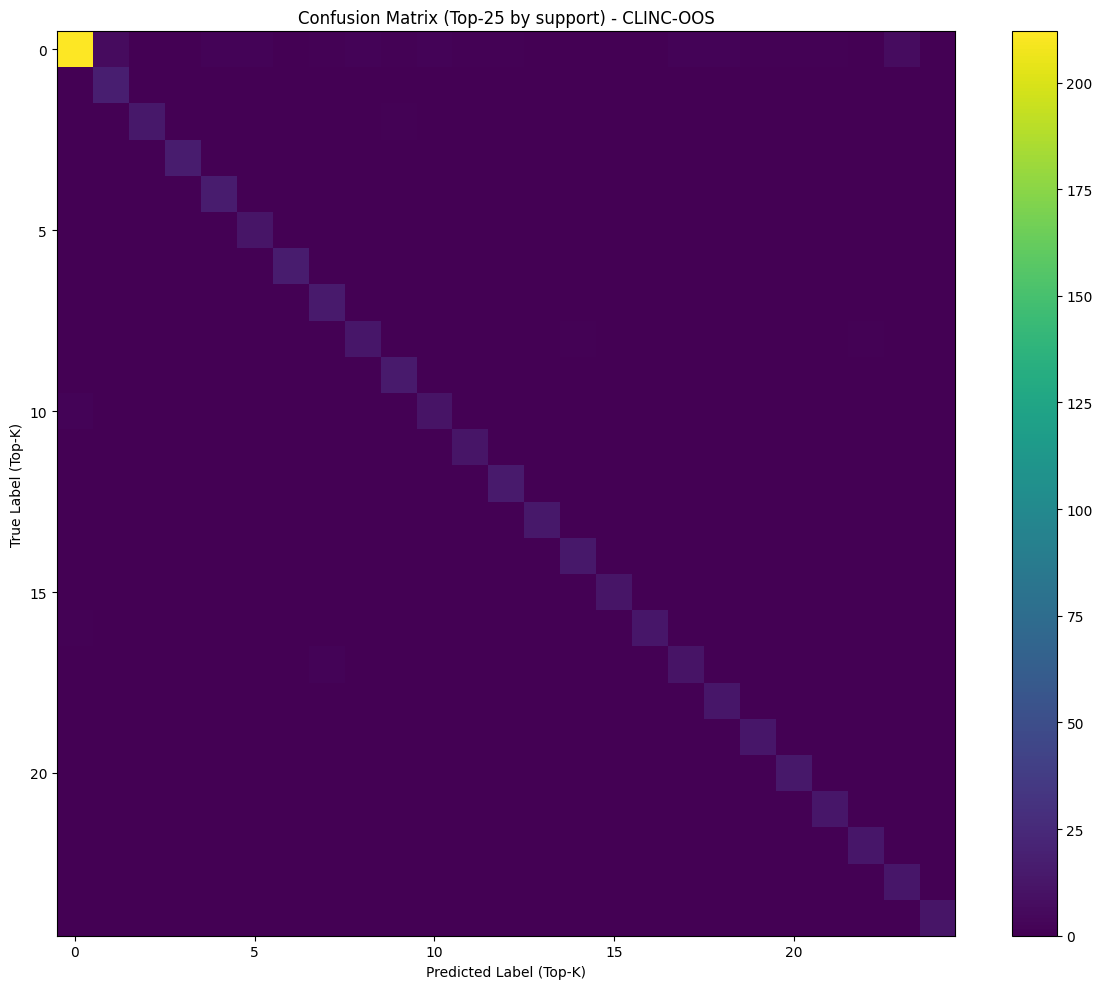

Saved: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/confusion_matrix_top25.png


In [21]:
# ✅ Cell 9C: Confusion Matrix (Top-K labels by support in y_true)
K = 25  # 20〜30が見やすい

y_true_s = pd.Series(y_true)
top_labels = y_true_s.value_counts().head(K).index.tolist()

cm_top = confusion_matrix(y_true, y_pred, labels=top_labels)

plt.figure(figsize=(12, 10))
plt.imshow(cm_top, aspect="auto")
plt.colorbar()
plt.xlabel("Predicted Label (Top-K)")
plt.ylabel("True Label (Top-K)")
plt.title(f"Confusion Matrix (Top-{K} by support) - CLINC-OOS")
plt.tight_layout()

top_path = ARTIFACTS["cm_png"].replace(".png", f"_top{K}.png")
plt.savefig(top_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", top_path)


In [22]:
# ✅ Cell 10: Error Analysis (save misclassifications to TSV)
errors = []
for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt != yp:
        # Get original example with text
        ex = test_ds2[i]
        errors.append({
            "idx": i,
            "true_id": int(yt),
            "pred_id": int(yp),
            "true_label": id2label[int(yt)],
            "pred_label": id2label[int(yp)],
            "text": ex["text"],
        })

err_df = pd.DataFrame(errors)
err_df.to_csv(ARTIFACTS["errors"], sep="\t", index=False)

print(f"\nTotal misclassifications: {len(errors)}")
print(f"Error rate: {len(errors)/len(test_ds2)*100:.2f}%")
print(f"Errors saved to: {ARTIFACTS['errors']}")
print(f"\nFirst 10 errors:")
print(err_df.head(10))



Total misclassifications: 281
Error rate: 14.05%
Errors saved to: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/errors.tsv

First 10 errors:
   idx  true_id  pred_id         true_label            pred_label  \
0    8       42       84                oos          order_status   
1   11       58      136     share_location      current_location   
2   14       42       17                oos            jump_start   
3   17       42      100                oos         rollover_401k   
4   22       75       11  what_is_your_name             user_name   
5   32       42       17                oos            jump_start   
6   35       42      131                oos  schedule_maintenance   
7   37      123        3    oil_change_when        oil_change_how   
8   38       71       93   spending_history                income   
9   42       42      119                oos          change_speed   

                                          text  
0  c

In [23]:
# ✅ BONUS Cell 11: Update Registry (track all runs)
# Create or update run registry
registry_data = {
    "run_id": ts,
    "run_dir": RUN_DIR,
    "model_name": cfg["model_name"],
    "dataset": cfg["dataset_name"],
    "num_labels": num_labels,
    "train_size": len(train_ds2),
    "val_size": len(val_ds2),
    "test_size": len(test_ds2),
    "best_val_loss": best_val_loss,
    "test_acc": test_acc,
    "test_f1": test_f1,
    "epochs_trained": ep,
    "timestamp": ts,
}

# Append to registry CSV
registry_path = ARTIFACTS["registry"]
if os.path.exists(registry_path):
    registry_df = pd.read_csv(registry_path)
    registry_df = pd.concat([registry_df, pd.DataFrame([registry_data])], ignore_index=True)
else:
    registry_df = pd.DataFrame([registry_data])

registry_df.to_csv(registry_path, index=False)
print(f"\nRun registry updated: {registry_path}")
print("\nAll runs:")
print(registry_df)

print("\n" + "="*70)
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print("="*70)
for k, v in ARTIFACTS.items():
    if os.path.exists(v):
        print(f"✓ {k}: {v}")
    else:
        print(f"✗ {k}: {v} (not created)")


Run registry updated: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/registry.csv

All runs:
            run_id                                            run_dir  \
0  20260208_120822  /Users/mh/Downloads/Mini Project/Feb2026/Feb_C...   
1  20260211_125638  /Users/mh/Downloads/Mini Project/Feb2026/Feb_C...   
2  20260211_160328  /Users/mh/Downloads/Mini Project/Feb2026/Feb_C...   
3  20260211_160328  /Users/mh/Downloads/Mini Project/Feb2026/Feb_C...   

                model_name    dataset  num_labels  train_size  val_size  \
0  distilbert-base-uncased  clinc_oos         151        8000      1000   
1  distilbert-base-uncased  clinc_oos         151        8000      1000   
2  distilbert-base-uncased  clinc_oos         151        8000      1000   
3  distilbert-base-uncased  clinc_oos         151        8000      1000   

   test_size  best_val_loss  test_acc   test_f1  epochs_trained  \
0       2000       0.611593    0.8400  0.874328               3   
1     

OOS misclassifications: 167 / 281 total errors

--- OOS が誤って割り当てられた先の intent Top-20 ---
pred_label
smart_home                 13
directions                  7
jump_start                  6
travel_suggestion           6
nutrition_info              5
make_call                   5
measurement_conversion      5
time                        4
next_holiday                4
text                        4
schedule_maintenance        4
plug_type                   4
pto_used                    3
calories                    3
ingredient_substitution     3
direct_deposit              3
sync_device                 3
bill_balance                3
spending_history            2
report_lost_card            2
Name: count, dtype: int64


/var/folders/hs/_m6yhr9s1tx1w63rz57dnyjw0000gn/T/ipykernel_32832/4100515571.py:18: UserWarning: Glyph 35492 (\N{CJK UNIFIED IDEOGRAPH-8AA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/hs/_m6yhr9s1tx1w63rz57dnyjw0000gn/T/ipykernel_32832/4100515571.py:18: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/hs/_m6yhr9s1tx1w63rz57dnyjw0000gn/T/ipykernel_32832/4100515571.py:18: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/hs/_m6yhr9s1tx1w63rz57dnyjw0000gn/T/ipykernel_32832/4100515571.py:18: UserWarning: Glyph 20808 (\N{CJK UNIFIED IDEOGRAPH-5148}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/hs/_m6yhr9s1tx1w63rz57dnyjw0000gn/T/ipykernel_32832/4100515571.py:18: UserWarning: Glyph 21463 (\N{CJK UNIFIED IDEOGRAPH-53D7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/hs/_m6y

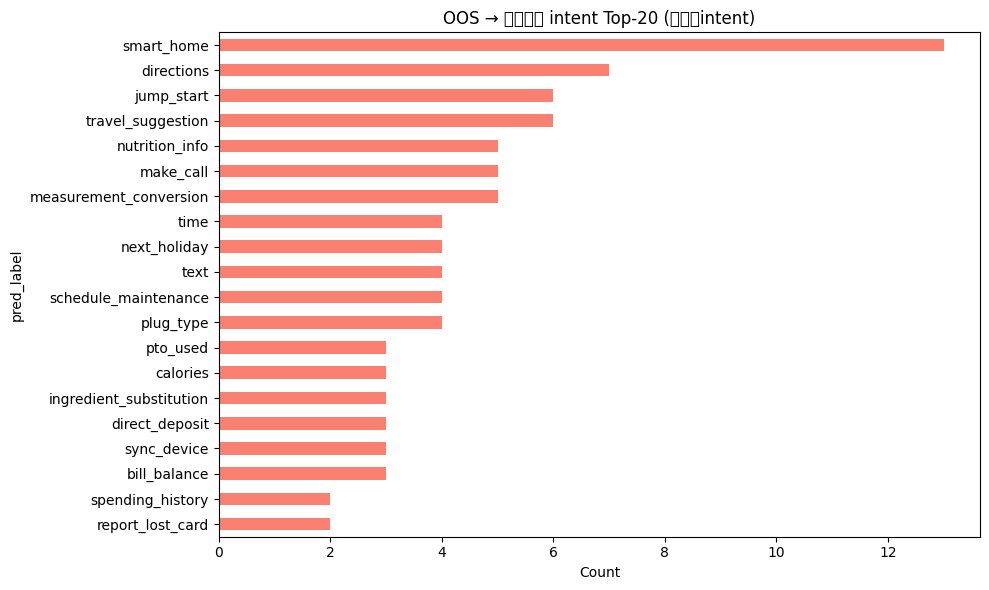


Saved: /Users/mh/Downloads/Mini Project/Feb2026/Feb_CLINCOOS_RunRegistry/runs/run_20260211_160328/confusion_matrix_oos_receiver.png

--- 上位3受け皿intentの具体テキスト例 ---

[smart_home] (13 件)
  • vacuum out the car
  • have you seen the remote
  • why would the water be turned off

[directions] (7 件)
  • where is the closest driving range
  • is there an alternate bus stop close to my home i can use
  • find directions to the sunshine car wash from my house

[jump_start] (6 件)
  • can you auto-pilot the car
  • can a samurai sword deflect a bullet
  • switch over to low power mode to preserve battery life


In [24]:
# ✅ Cell 12: OOS Error Analysis — "受け皿intent" 特定
# true_label == "oos" のサンプルが誤分類された先の intent Top-20

oos_errors = err_df[err_df["true_label"] == "oos"]
print(f"OOS misclassifications: {len(oos_errors)} / {len(err_df)} total errors")
print(f"\n--- OOS が誤って割り当てられた先の intent Top-20 ---")
print(oos_errors["pred_label"].value_counts().head(20))

# 可視化
import matplotlib.pyplot as plt

top20 = oos_errors["pred_label"].value_counts().head(20)
fig, ax = plt.subplots(figsize=(10, 6))
top20.plot.barh(ax=ax, color="salmon")
ax.invert_yaxis()
ax.set_xlabel("Count")
ax.set_title("OOS → 誤分類先 intent Top-20 (受け皿intent)")
plt.tight_layout()

oos_cm_path = ARTIFACTS["cm_png"].replace(".png", "_oos_receiver.png")
plt.savefig(oos_cm_path, dpi=200, bbox_inches="tight")
plt.show()
print(f"\nSaved: {oos_cm_path}")

# テキスト例も確認（上位3 intentの具体例）
print("\n--- 上位3受け皿intentの具体テキスト例 ---")
for intent in top20.index[:3]:
    subset = oos_errors[oos_errors["pred_label"] == intent]
    print(f"\n[{intent}] ({len(subset)} 件)")
    for _, row in subset.head(3).iterrows():
        print(f"  • {row['text']}")